# Setup

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os 
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [22]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"


reports_lsa = "../../../reports/reports_nohubs/analisis_lsa/"
matrix_path = reports_lsa + "lsa_node_data.npz"
row_path = reports_lsa + "node_matrix_index.txt"
vocab_path = reports_lsa + "component_vobab_nodos.pkl"

reports_tfidf = "../../../reports/reports_nohubs/analisis_tfidf/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
infomap_analysis = pd.read_pickle(reports_tfidf + "infomap_analysis_checkpoint.pkl")
louvain_analysis = pd.read_pickle(reports_tfidf + "louvain_analysis_checkpoint.pkl")


mat = sparse.load_npz(matrix_path)
rows = np.loadtxt(row_path).astype(int)
vocab = pd.read_pickle(vocab_path)

In [15]:
lsa_data = pd.DataFrame.sparse.from_spmatrix(mat, index=rows)

# Kmeans clustering

(lo sig. copypasteado de sklearn)

In [18]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [24]:
true_k_infomap = len(infomap_analysis)
true_k_louvain = len(louvain_analysis)

In [28]:
transformer = Normalizer()
X_lsa = mat.toarray()
X_lsa = transformer.fit_transform(X_lsa)

In [43]:
kmeans_infomap = KMeans(
    n_clusters=true_k_infomap,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans_infomap, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 19.68 ± 4.81 s 
Silhouette Coefficient: 0.232 ± 0.003


In [44]:
kmeans_louvain = KMeans(
    n_clusters=true_k_louvain,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans_louvain, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 7.67 ± 1.54 s 
Silhouette Coefficient: 0.223 ± 0.005


In [47]:
infomap_labels = kmeans_infomap.labels_
louvain_labels = kmeans_louvain.labels_

node_clusters = graph_node_data[["node_name","node_index","comunidades_infomap","comunidades_louvain"]].dropna()

In [68]:
infomap_labels_df = pd.DataFrame(infomap_labels, index=rows, columns=["infomap_kmeans_label"])
louvain_labels_df = pd.DataFrame(louvain_labels, index=rows, columns=["louvain_kmeans_label"])

kmeans_labels = pd.concat([infomap_labels_df,louvain_labels_df], axis=1)

In [74]:
node_labels = pd.merge(node_clusters, kmeans_labels, left_on="node_index", right_index=True)
node_labels.to_csv(reports_lsa+"kmeans_clustering_labels.csv",index=False)

In [72]:
node_labels

,node_name,node_index,comunidades_infomap,comunidades_louvain,infomap_kmeans_label,louvain_kmeans_label
8,Schizophrenia,20754,0.0,0.0,614,141
16,Malignant neoplasm of prostate,24165,3.0,2.0,1078,139
17,Malignant neoplasm of breast,18773,11.0,3.0,841,273
18,Bladder Neoplasm,18732,28.0,3.0,299,68
21,Malignant neoplasm of urinary bladder,18728,28.0,3.0,299,68
...,...,...,...,...,...,...
35834,"AMYLOID CARDIOMYOPATHY, TRANSTHYRETIN-RELATED",30820,766.0,22.0,589,153
35835,"BERNARD-SOULIER SYNDROME, TYPE A1",30959,1106.0,252.0,121,42
35836,Triple-Negative Breast Carcinoma,33955,17.0,2.0,386,273
35837,DOCK8 Deficiency,32968,127.0,17.0,454,187


# Comparo particiones con clustering

In [81]:
# Unión: |, Intersección: &
def jaccard(set1,set2):
    intersection = len(set1&set2)
    union = len(set1|set2)
    return intersection/union

def int_min(set1,set2):
    intersection = len(set1&set2)
    min_set = np.min([len(set1),len(set2)])
    return intersection/min_set

def int_max(set1,set2):
    intersection = len(set1&set2)
    max_set = np.max([len(set1),len(set2)])
    return intersection/max_set

In [75]:
node_labels

,node_name,node_index,comunidades_infomap,comunidades_louvain,infomap_kmeans_label,louvain_kmeans_label
8,Schizophrenia,20754,0.0,0.0,614,141
16,Malignant neoplasm of prostate,24165,3.0,2.0,1078,139
17,Malignant neoplasm of breast,18773,11.0,3.0,841,273
18,Bladder Neoplasm,18732,28.0,3.0,299,68
21,Malignant neoplasm of urinary bladder,18728,28.0,3.0,299,68
...,...,...,...,...,...,...
35834,"AMYLOID CARDIOMYOPATHY, TRANSTHYRETIN-RELATED",30820,766.0,22.0,589,153
35835,"BERNARD-SOULIER SYNDROME, TYPE A1",30959,1106.0,252.0,121,42
35836,Triple-Negative Breast Carcinoma,33955,17.0,2.0,386,273
35837,DOCK8 Deficiency,32968,127.0,17.0,454,187


In [77]:
comunidades_infomap = infomap_analysis.comunidad.values
comunidades_louvain = louvain_analysis.comunidad.values 

conjuntos_infomap = {int(comunidad):set(node_labels.loc[node_labels.comunidades_infomap == comunidad,"node_index"].values) for comunidad in comunidades_infomap}
conjuntos_louvain = {int(comunidad):set(node_labels.loc[node_labels.comunidades_louvain == comunidad,"node_index"].values) for comunidad in comunidades_louvain}

conjuntos_kmeans_infomap = {int(cluster):set(node_labels.loc[node_labels.infomap_kmeans_label == cluster,"node_index"].values) for cluster in infomap_labels}
conjuntos_kmeans_louvain = {int(cluster):set(node_labels.loc[node_labels.louvain_kmeans_label == cluster,"node_index"].values) for cluster in louvain_labels}

In [87]:
matrix_jaccard = {}
matrix_min = {}
matrix_max = {}

for comunidad_infomap,set_infomap in conjuntos_infomap.items():
    partial_jaccard = {}
    partial_min = {}
    partial_max = {}
    for kmeans_infomap, set_kmeans_infomap in conjuntos_kmeans_infomap.items():
        coef_jaccard = jaccard(set_infomap,set_kmeans_infomap)
        coef_min = int_min(set_infomap,set_kmeans_infomap)
        coef_max = int_max(set_infomap,set_kmeans_infomap)
        partial_jaccard[kmeans_infomap] = coef_jaccard
        partial_min[kmeans_infomap] = coef_min
        partial_max[kmeans_infomap] = coef_max
    matrix_jaccard[comunidad_infomap] = partial_jaccard
    matrix_min[comunidad_infomap] = partial_min
    matrix_max[comunidad_infomap] = partial_max


df_jaccard = pd.DataFrame(matrix_jaccard)
df_min = pd.DataFrame(matrix_min)
df_max = pd.DataFrame(matrix_max)

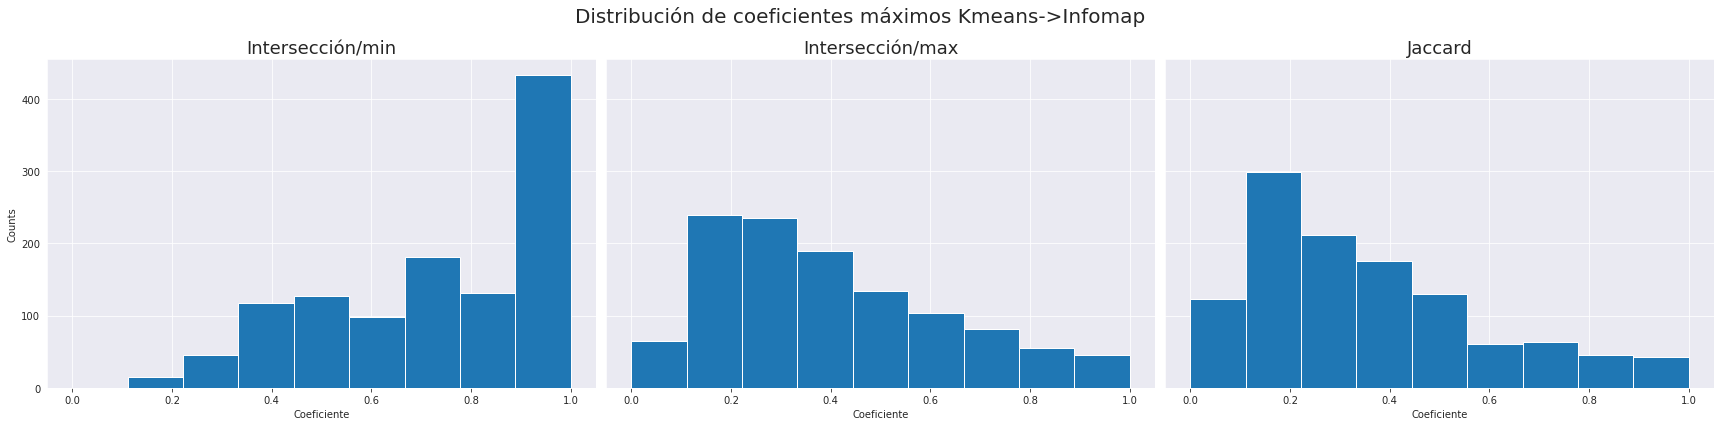

In [94]:
metricas = {"Intersección/min":df_min,"Intersección/max":df_max, "Jaccard":df_jaccard}

fig, ax = plt.subplots(1,3, figsize=(24,6), sharey=True)
fig.suptitle("Distribución de coeficientes máximos Kmeans->Infomap", fontsize=20)
i=0
for name,data in metricas.items():
    ax[i].hist(data.T.max().values, bins=np.linspace(0,1,10))
    ax[i].set_title(f"{name}", fontsize=18)
    ax[i].set_xlabel("Coeficiente")
    i+=1

ax[0].set_ylabel("Counts")

plt.tight_layout()

In [102]:
node_labels[node_labels.infomap_kmeans_label == 0]

,node_name,node_index,comunidades_infomap,comunidades_louvain,infomap_kmeans_label,louvain_kmeans_label
4178,Anemia,18545,303.0,12.0,0,0
6427,"Anemia, Hemolytic",18550,274.0,51.0,0,0
18865,"Anemia, Sickle Cell",18565,78.0,32.0,0,0
19690,"Anemia, Megaloblastic",18558,582.0,12.0,0,0
25467,Heinz Body Anemias,25081,274.0,51.0,0,0
25771,"Anemia, Macrocytic",18557,582.0,12.0,0,0
31012,"Rh-Null, Regulator Type",28111,701.0,71.0,0,0
31016,Rh Deficiency Syndrome,23276,701.0,71.0,0,0
31450,Pseudohyperkalemia Cardiff,28802,701.0,71.0,0,0
31681,"Anemia, Neonatal",18561,303.0,12.0,0,0


In [104]:
node_labels[node_labels.comunidades_infomap == 701]

,node_name,node_index,comunidades_infomap,comunidades_louvain,infomap_kmeans_label,louvain_kmeans_label
1864,"Pseudohyperkalemia, Familial, 2, due to Red Ce...",27453,701.0,71.0,932,0
21182,"Elliptocytosis, Hereditary",19209,701.0,71.0,311,0
27027,Xerocytosis,23275,701.0,71.0,932,0
27028,DEHYDRATED HEREDITARY STOMATOCYTOSIS 2,32679,701.0,71.0,231,165
31012,"Rh-Null, Regulator Type",28111,701.0,71.0,0,0
31014,STOMATOCYTOSIS I,28803,701.0,71.0,311,0
31016,Rh Deficiency Syndrome,23276,701.0,71.0,0,0
31435,"Cryohydrocytosis, Stomatin-Deficient, with Men...",27497,701.0,71.0,311,0
31449,Elliptocytosis 4,28860,701.0,71.0,932,0
31450,Pseudohyperkalemia Cardiff,28802,701.0,71.0,0,0
